# Aim
Characterize the SEAL closed-loop delay and try to build that into the controller.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import re
sys.path.append("..")
from src import *
fs = 100

Running in simulation mode.
Updated the flat image.


In [164]:
def stamp_to_seconds(t):
    h, m, s, ms = [int(x) for x in re.search("(\d+):(\d+):(\d+),(\d+)", t).groups()]
    return 3600 * h + 60 * m + s + 0.001 * ms

In [152]:
exposures = []
states = []
dmcs = []
no_delay_fnames = ["01_06", "01_35", "02_15", "03_01"]
dt_o10_fnames = ["05_56", "06_37", "06_54", "07_12"]
dt_o5_fnames = ["08_08", "08_25", "08_41", "08_59"]
dt_o2_fnames = ["21_10", "21_30", "21_53", "22_13", "24_51", "25_37"]
dt_o50_fnames = ["26_41", "27_28", "27_44", "28_28", "29_03", "30_04"]
dt_o100_fnames = ["31_36", "32_07", "32_46", "34_30"]
for fname in dt_o50_fnames:
    seen_state_before = False
    temp_exposures = []
    with open(joindata("log", f"log_13_11_2021_04_{fname}.log")) as file:
        for line in file:
            time = re.search("\d+:\d+:\d+,\d+", line)[0]
            seconds = stamp_to_seconds(time)
            event = re.search("INFO \| (.+)", line)[1]
            if event.startswith("Exposure"):
                exposures.append(seconds)
            elif event.startswith("state"):
                states.append(seconds)
            elif event.startswith("DMC"):
                dmcs.append(seconds)

t0 = exposures[0]
exposures = np.array(exposures) - t0
states = np.array(states) - t0
dmcs = np.array(dmcs) - t0

([], [])

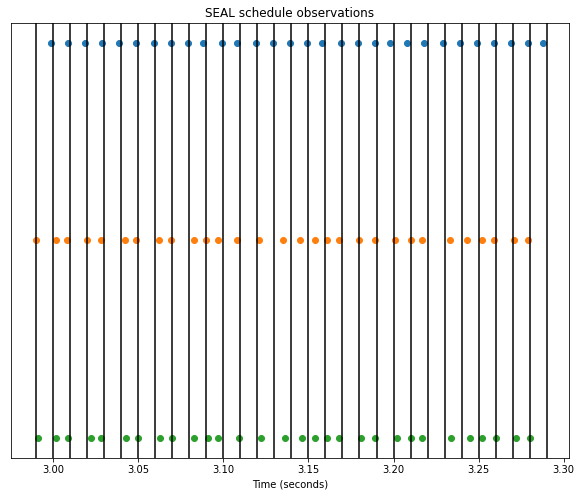

In [160]:
nstart = 300
npoints = 30
plt.figure(figsize=(10,8))
plt.scatter(exposures[nstart:nstart+npoints], 1.5*np.ones_like(exposures[nstart:nstart+npoints]), label="exposures")
plt.scatter(states[nstart:nstart+npoints], np.ones_like(states[nstart:nstart+npoints]), label="states")
plt.scatter(dmcs[nstart:nstart+npoints], 0.5*np.ones_like(dmcs[nstart:nstart+npoints]), label="dmcs")
min_time = exposures[nstart]
max_time = dmcs[nstart+npoints-1]
for v in np.arange(np.round(min_time, decimals=2)-0.01, np.round(max_time, decimals=2)+0.02, 0.01):
    plt.axvline(v, color='k')
plt.title("SEAL schedule observations")
plt.xlabel("Time (seconds)")
plt.yticks([])
#plt.legend()

In [161]:
len(exposures), len(states), len(dmcs)

(4002, 4002, 4002)

In [162]:
if len(exposures) > len(states):
    diff = len(exposures) - len(states)
    means = np.zeros(diff)
    for i in range(diff):
        delay_candidate = states - exposures[i:i+len(states)]
        if np.any(delay_candidate < 0):
            means[i] = np.inf
        else:
            means[i] = np.mean(delay_candidate)
    means[means < 0] = np.inf
    offset = np.argmin(means)
elif len(exposures) < len(states):
    states = states[-len(exposures):]
    dmcs = dmcs[-len(exposures):]
measure_delays = (states - exposures[offset:offset+len(states)]) * fs
num_meas_bins = int(max(measure_delays) * 1000 / fs) + 1
control_delays = (dmcs - states) * fs
num_cont_bins = int(max(control_delays) * 1000 / fs) + 1

Text(0.5, 1.0, 'Controller frame delay')

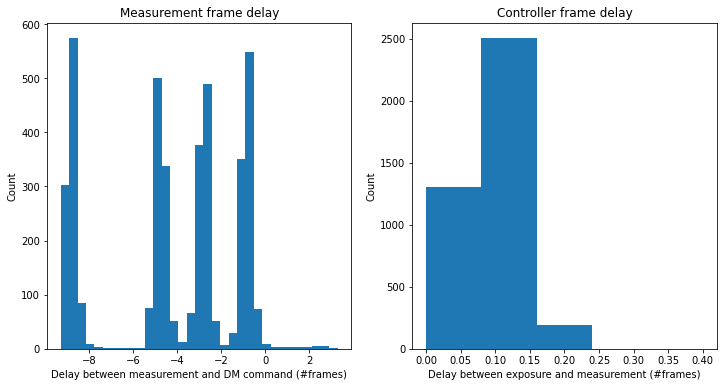

In [163]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].hist(measure_delays[np.abs(measure_delays) < 10], bins=min(50, num_meas_bins));
axs[0].set_xlabel("Delay between measurement and DM command (#frames)")
axs[0].set_ylabel("Count")
axs[0].set_title("Measurement frame delay")
axs[1].hist(control_delays, bins=min(100, num_cont_bins));
axs[1].set_xlabel("Delay between exposure and measurement (#frames)")
axs[1].set_ylabel("Count")
axs[1].set_title("Controller frame delay")